<img style="float: left; padding-right: 10px; width: 45px" src="https://upload.wikimedia.org/wikipedia/fr/b/b1/Logo_EPF.png?raw=true"> 

# Introduction to Machine Learning


## Lab 1:  Multiple and Polynomial Regression

### First name: Douae 
### Last name: HAMMOUTI
### Group: DEA2


---

## Table of Contents

<ol start="0">
<li> Learning Goals </li>
<li> Polynomial Regression, and Revisiting the Cab Data</li>
<li> Multiple regression and exploring the Football data </li>
<li> A nice trick for forward-backwards </li>
</ol>

## Learning Goals
After this lab, you should be able to
 - Implement arbitrary multiple regression models in both SK-learn and Statsmodels
 - Interpret the coefficent estimates produced by each model, including transformed and dummy variables

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

`statsmodels` is focused on the _inference_ task: guess good values for the betas and discuss how certain you are in those answers. 

`sklearn` is focused on the _prediction_ task: given \[new\] data, guess what the response value is. As a result, statsmodels has lots of tools to discuss confidence, but isn't great at dealing with test sets. Sklearn is great at test sets and validations, but can't really discuss uncertainty in the parameters or predictions. In short:

  - sklearn is about putting a line through it and predicting new values using that line. If the line gives good predictions on the test set, who cares about anything else?
  - statsmodels assumes more about how the data were generated, and (if the assumptions are correct) can tell you about uncertainty in the results


### Some terms


- **R-squared**: An interpretable summary of how well the model did. 1 is perfect, 0 is a trivial baseline model, negative is worse than the trivial model
- **F-statistic**: A value testing whether we're likely to see these results (or even stronger ones) if none of the predictors actually mattered.
- **Prob (F-statistic)**: The probability that we'd see these results (or even stronger ones) if none of the predictors actually mattered. If this probability is small then either A) some combination of predictors actually matters or B) something rather unlikely has happened
- **coef**: The estimate of each beta. This has several sub-components:
  - **std err**: The amount we'd expect this value to wiggle if we re-did the data collection and re-ran our model. More data tends to make this wiggle smaller, but sometimes the collected data just isn't enough to pin down a particular value.
  - **t and P>|t|**: similar to the F-statistic, these measure the probability of seeing coefficients this big (or even bigger) if the given variable didn't actually matter. Small probability doesn't necessarily mean the value matters
  - **\[0.025 0.975\]**: Endpoints of the 95% confidence interval. This is a interval drawn in a clever way and which gives an idea of where the true beta value might plausibly live. (If you want to understand why "there's a 95% chance the true beta is in the interval" is _wrong_, start a chat with Will : )
  

## Part 1: Polynomial Regression, and Revisiting the Cab Data

In [4]:
# read in the data, break into train and test
cab_df = pd.read_csv("dataset_1.txt")
train_data, test_data = train_test_split(cab_df, test_size=.2, random_state=42)
cab_df.head()

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [5]:
cab_df.shape

(1250, 2)

In [6]:
# do some data cleaning
X_train = train_data['TimeMin'].values.reshape(-1,1)/60
y_train = train_data['PickupCount'].values

X_test = test_data['TimeMin'].values.reshape(-1,1)/60
y_test = test_data['PickupCount'].values


def plot_cabs(cur_model, poly_transformer=None):
    
    # build the x values for the prediction line
    x_vals = np.arange(0,24,.1).reshape(-1,1)
    
    # if needed, build the design matrix
    if poly_transformer:
        design_mat = poly_transformer.fit_transform(x_vals)
    else:
        design_mat = x_vals
    
    # make the prediction at each x value
    prediction = cur_model.predict(design_mat)
    
    # plot the prediction line, and the test data
    plt.plot(x_vals,prediction, color='k', label="Prediction")
    plt.scatter(X_test, y_test, label="Test Data")

    # label your plots
    plt.ylabel("Number of Taxi Pickups")
    plt.xlabel("Time of Day (Hours Past Midnight)")
    plt.legend()
    plt.show()

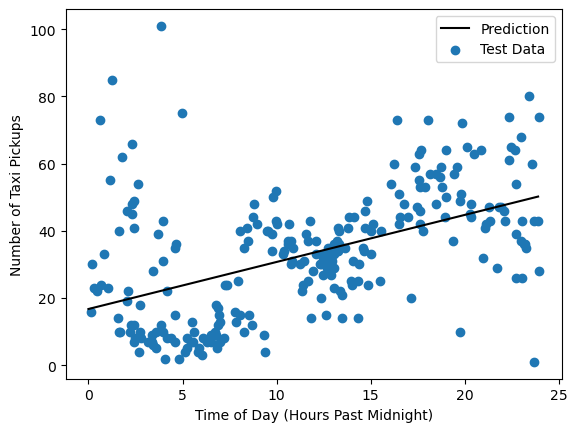

In [7]:
from sklearn.linear_model import LinearRegression
fitted_cab_model0 = LinearRegression().fit(X_train, y_train)
plot_cabs(fitted_cab_model0)

In [8]:
fitted_cab_model0.score(X_test, y_test)

0.240661535615741

We can see that there's still a lot of variation in cab pickups that's not being caught by a linear fit. And the linear fit is predicting massively more pickups at 11:59pm than at 12:00am. However, we can add columns to our design matrix for $TimeMin^2$ and $TimeMin^3$ and so on, allowing a wigglier polynomial that will better fit the data.

We'll be using sklearn's `PolynomialFeatures` to take some of the tedium out of building the new design matrix. In fact, if all we want is a formula like $y \approx \beta_0 + \beta_1 x + \beta_2 x^2 + ...$ it will directly return the new design matrix.

In [9]:
transformer_3 = PolynomialFeatures(3, include_bias=False)
new_features = transformer_3.fit_transform(X_train)
new_features

array([[6.73333333e+00, 4.53377778e+01, 3.05274370e+02],
       [2.18333333e+00, 4.76694444e+00, 1.04078287e+01],
       [1.41666667e+00, 2.00694444e+00, 2.84317130e+00],
       ...,
       [1.96666667e+01, 3.86777778e+02, 7.60662963e+03],
       [1.17333333e+01, 1.37671111e+02, 1.61534104e+03],
       [1.42000000e+01, 2.01640000e+02, 2.86328800e+03]])

A few notes on `PolynomialFeatures`:

- The interface is a bit strange. `PolynomialFeatures` is a 'transformer' in sklearn. We'll be using several transformers that learn a transformation on the training data and then apply that transformation on future data. On these (more typical) transformers it makes sense to have a `.fit()` and a separate `.transform()`. With PolynomialFeatures, the `.fit()` is pretty trivial, and we often fit and transform in one command, as seen above.
- You rarely want to `include_bias` (a column of all 1s), since sklearn will add it automatically and statsmodels can just `add_constant` right before you fit to the design matrix
- If you want polynomial features for a several different variables, you should call `.fit_transform()` separately on each column and append all the results to the design matrix (unless you also want interaction terms between the newly-created features). See `np.concatenate` for joining arrays.

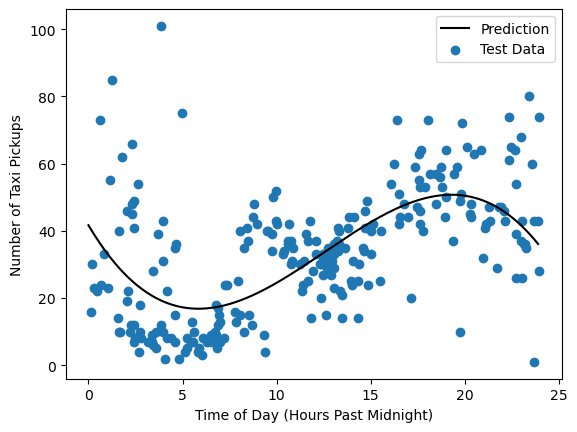

In [10]:
fitted_cab_model3 = LinearRegression().fit(new_features, y_train)
plot_cabs(fitted_cab_model3, transformer_3)

<div class="exercise"><b>Exercise</b></div>

**Questions**:
1. Calculate the polynomial model's $R^2$ performance on the test set. 
2. Does the polynomial model improve on the purely linear model?
3. Make a residual plot for the polynomial model. What does this plot tell us about the model?

*your answer here*


In [ ]:
# your code here
from sklearn.metrics import r2_score

X_test_poly = transformer_3.transform(X_test)
y_pred_poly = fitted_cab_model3.predict(X_test_poly)

r2_poly = r2_score(y_test, y_pred_poly)
print("Polynomial model R^2 score:", r2_poly)


Polynomial model R^2 score: 0.3341251257077831


In [12]:
# your code here
r2_linear = fitted_cab_model0.score(X_test, y_test)
print("Linear model R^2 score:", r2_linear)

if r2_poly > r2_linear:
    print("✅ The polynomial model improves on the linear model.")
else:
    print("❌ The polynomial model does NOT improve on the linear model.")


Linear model R^2 score: 0.240661535615741
✅ The polynomial model improves on the linear model.


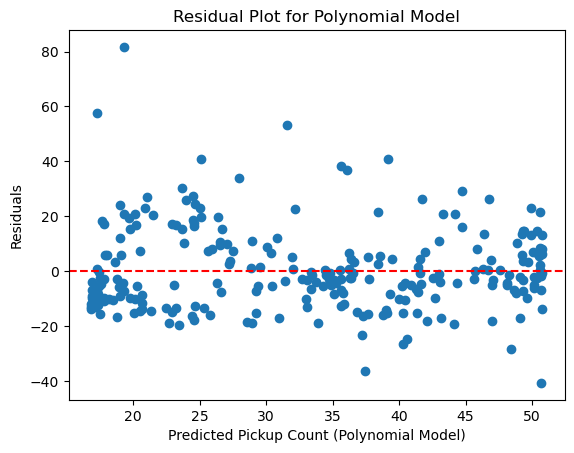

In [13]:
# your code here

# Residuals
residuals = y_test - y_pred_poly

# Residual plot
plt.scatter(y_pred_poly, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Pickup Count (Polynomial Model)")
plt.ylabel("Residuals")
plt.title("Residual Plot for Polynomial Model")
plt.show()


#### Other features
Polynomial features are not the only constucted features that help fit the data. Because these data have a 24 hour cycle, we may want to build features that follow such a cycle. For example, $sin(24\frac{x}{2\pi})$, $sin(12\frac{x}{2\pi})$, $sin(8\frac{x}{2\pi})$. Other feature transformations are appropriate to other types of data. For instance certain feature transformations have been developed for geographical data.

<hr style="height:3px">
## Part 2: Multiple regression and exploring the Football data
Let's move on to a truly interesting dataset. The data imported below were scraped by [Shubham Maurya](https://www.kaggle.com/mauryashubham/linear-regression-to-predict-market-value/data) and record various facts about players in the English Premier League. Our goal will be to fit models that predict the players' market value (what the player could earn when hired by a new team), as estimated by transfermrkt.com.

`name`: Name of the player  
`club`: Club of the player  
`age` : Age of the player  
`position` : The usual position on the pitch  
`position_cat` :  1 for attackers, 2 for midfielders, 3 for defenders, 4 for goalkeepers  
`market_value` : As on transfermrkt.com on July 20th, 2017  
`page_views` : Average daily Wikipedia page views from September 1, 2016 to May 1, 2017  
`fpl_value` : Value in Fantasy Premier League as on July 20th, 2017  
`fpl_sel` : % of FPL players who have selected that player in their team  
`fpl_points` : FPL points accumulated over the previous season  
`region`: 1 for England, 2 for EU, 3 for Americas, 4 for Rest of World  
`nationality`: Player's nationality  
`new_foreign`: Whether a new signing from a different league, for 2017/18 (till 20th July)  
`age_cat`: a categorical version of the Age feature  
`club_id`: a numerical version of the Club feature  
`big_club`: Whether one of the Top 6 clubs  
`new_signing`: Whether a new signing for 2017/18 (till 20th July)  

As always, we first import, verify, split, and explore the data.

## Part 2.1: Import and verification and grouping

In [14]:
league_df = pd.read_csv("league_data.txt")
print(league_df.dtypes)
league_df.head()

name             object
club             object
age               int64
position         object
position_cat      int64
market_value    float64
page_views        int64
fpl_value       float64
fpl_sel          object
fpl_points        int64
region          float64
nationality      object
new_foreign       int64
age_cat           int64
club_id           int64
big_club          int64
new_signing       int64
dtype: object


,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


In [15]:
league_df.shape

(461, 17)

In [16]:
league_df.describe()

,age,position_cat,market_value,page_views,fpl_value,fpl_points,region,new_foreign,age_cat,club_id,big_club,new_signing
count,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,460.000000,461.000000,461.000000,461.000000,461.000000,461.000000
mean,26.804772,2.180043,11.012039,763.776573,5.447939,57.314534,1.993478,0.034707,3.206074,10.334056,0.303688,0.145336
std,3.961892,1.000061,12.257403,931.805757,1.346695,53.113811,0.957689,0.183236,1.279795,5.726475,0.460349,0.352822
min,17.000000,1.000000,0.050000,3.000000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,24.000000,1.000000,3.000000,220.000000,4.500000,5.000000,1.000000,0.000000,2.000000,6.000000,0.000000,0.000000
50%,27.000000,2.000000,7.000000,460.000000,5.000000,51.000000,2.000000,0.000000,3.000000,10.000000,0.000000,0.000000
75%,30.000000,3.000000,15.000000,896.000000,5.500000,94.000000,2.000000,0.000000,4.000000,15.000000,1.000000,0.000000
max,38.000000,4.000000,75.000000,7664.000000,12.500000,264.000000,4.000000,1.000000,6.000000,20.000000,1.000000,1.000000


### (Stratified) train/test split
We want to make sure that the training and test data have appropriate representation of each region; it would be bad for the training data to entirely miss a region. This is especially important because some regions are rather rare.

<div class="exercise"><b>Exercise</b></div>
**Questions**:
1. Use the `train_test_split` function to and its 'stratify' argument to split the data, keeping equal representation of each region (This will not work out of the box on this data. Deal with the resulting issue).
2. Deal with the issue you encountered above.
3. How did you deal with the error generated by `train_test_split`? How did you justify your action? 

*your answer here*:


In [27]:
# your code here

# Check counts of players per region
region_counts = league_df['region'].value_counts()
print(region_counts)

# Select regions with at least 2 players (or any threshold you want)
valid_regions = region_counts[region_counts >= 2].index

# Filter the original dataframe to only keep these regions
filtered_league_df = league_df[league_df['region'].isin(valid_regions)]

# Now you can safely stratify on 'region' when splitting
from sklearn.model_selection import train_test_split
league_train, league_test = train_test_split(
    filtered_league_df,
    test_size=0.2,
    random_state=42,
    stratify=filtered_league_df['region']
)


region
2.0    207
1.0    156
4.0     56
3.0     41
Name: count, dtype: int64


In [33]:
league_test.shape, league_train.shape

((92, 17), (368, 17))

Now that we won't be peeking at the test set, let's explore and look for patterns! We'll introduce a number of useful pandas and numpy functions along the way. 

### Groupby
Pandas' `.groupby()` function is a wonderful tool for data analysis. It allows us to analyze each of several subgroups.

Many times, `.groupby()` is combined with `.agg()` to get a summary statistic for each subgroup. For instance: What is the average market value, median page views, and maximum fpl for each player position?

In [31]:
league_train.groupby('position').agg({
    'market_value': np.mean,
    'page_views': np.median,
    'fpl_points': np.max
})

C:\Users\douae\AppData\Local\Temp\ipykernel_11904\2958919961.py:1: FutureWarning: The provided callable <function mean at 0x000002466C2C2980> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  league_train.groupby('position').agg({
C:\Users\douae\AppData\Local\Temp\ipykernel_11904\2958919961.py:1: FutureWarning: The provided callable <function median at 0x000002466C3F9440> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  league_train.groupby('position').agg({
C:\Users\douae\AppData\Local\Temp\ipykernel_11904\2958919961.py:1: FutureWarning: The provided callable <function max at 0x000002466C2C1F80> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass

,market_value,page_views,fpl_points
position,,,
AM,25.983333,861.0,218
CB,8.034127,273.0,178
CF,13.433673,748.0,224
CM,11.355000,436.0,225
DM,13.803571,556.5,131
GK,6.381429,395.0,149
LB,8.393939,380.0,177
LM,4.450000,347.0,95
LW,12.367308,495.0,224


In [ ]:
league_train.position.unique()

array(['CB', 'RB', 'CF', 'RW', 'GK', 'LW', 'CM', 'AM', 'LB', 'DM', 'SS',
       'LM', 'RM'], dtype=object)

In [35]:
league_train.groupby(['big_club', 'position']).agg({
    'market_value': np.mean,
    'page_views': np.mean,
    'fpl_points': np.mean
})

C:\Users\douae\AppData\Local\Temp\ipykernel_11904\2860371636.py:1: FutureWarning: The provided callable <function mean at 0x000002466C2C2980> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  league_train.groupby(['big_club', 'position']).agg({
C:\Users\douae\AppData\Local\Temp\ipykernel_11904\2860371636.py:1: FutureWarning: The provided callable <function mean at 0x000002466C2C2980> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  league_train.groupby(['big_club', 'position']).agg({


market_value   page_views  fpl_points
big_club position                                       
0        AM           12.468750   469.750000   61.125000
         CB            4.332979   287.617021   44.936170
         CF            7.522727   756.000000   48.909091
         CM            5.816176   345.058824   41.588235
         DM            8.250000   448.312500   49.375000
         GK            3.945652   318.260870   46.521739
         LB            5.000000   252.869565   49.869565
         LM            4.450000   396.200000   43.600000
         LW            6.527778   485.000000   43.944444
         RB            4.250000   272.000000   50.952381
         RM            4.333333   280.333333    1.666667
         RW            8.170455   574.363636   52.681818
         SS            7.500000  2614.750000   73.000000
1        AM           41.428571  2590.714286  152.714286
         CB           18.906250   924.500000   63.687500
         CF           25.625000  2209.812500   77.562500
         CM           23.125000  1890.687500   76.125000
         DM           21.208333  1266.250000   69.666667
         GK           11.050000   670.333333   60.083333
         LB           16.200000   875.200000   66.500000
         LW           25.506250  2065.875000  101.000000
         RB           16.611111   974.222222   90.888889
         RM           18.000000  2537.000000  105.000000
         RW           28.250000  1415.750000   78.000000

<hr style="height:3px">
## Part 2.2: Linear regression on the football data
This section of the lab focuses on fitting a model to the football data and interpreting the model results. The model we'll use is

$$\text{market_value} \approx \beta_0 + \beta_1\text{fpl_points} + \beta_2\text{age} + \beta_3\text{age}^2 + \beta_4log_2\left(\text{page_views}\right) + \beta_5\text{new_signing} +\beta_6\text{big_club} + \beta_7\text{position_cat}$$

We're including a 2nd degree polynomial in age because we expect pay to increase as a player gains experience, but then decrease as they continue aging. We're taking the log of page views because they have such a large, skewed range and the transformed variable will have fewer outliers that could bias the line. We choose the base of the log to be 2 just to make interpretation cleaner.

<div class="exercise"><b>Exercise</b></div>
**Questions**:
1. Build a design matrix function and fit this model to the training data. How good is the overall model?
2. Interpret the regression model. What is the meaning of the coefficient for:
    - age and age$^2$
    - $log_2($page_views$)$
    - big_club
2. What should a player do in order to improve their market value? How many page views should a player go get to increase their market value by 10?

In [47]:
def build_design_matrix(df):
    X = pd.DataFrame()
    X['fpl_points'] = df['fpl_points']
    X['age'] = df['age']
    X['age_squared'] = df['age'] ** 2
    X['log2_page_views'] = np.log2(df['page_views'] + 1)
    X['new_signing'] = df['new_signing']
    X['big_club'] = df['big_club']
    X['position_cat'] = df['position_cat']
    return X

X_train = build_design_matrix(league_train)
y_train = league_train['market_value']
X_test = build_design_matrix(league_test)
y_test = league_test['market_value']




In [40]:
# your code here

X_train_sm = sm.add_constant(X_train)
fitted_model_1 = sm.OLS(y_train, X_train_sm).fit()

# STEP 3: Model evaluation
print(fitted_model_1.summary())

                            OLS Regression Results                            
Dep. Variable:           market_value   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     96.16
Date:                Fri, 23 May 2025   Prob (F-statistic):           1.79e-78
Time:                        20:46:57   Log-Likelihood:                -1247.0
No. Observations:                 368   AIC:                             2510.
Df Residuals:                     360   BIC:                             2541.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -74.8329     14.208     

*your answer here*


In [41]:
agecoef = fitted_model_1.params.age
age2coef = fitted_model_1.params.age_squared

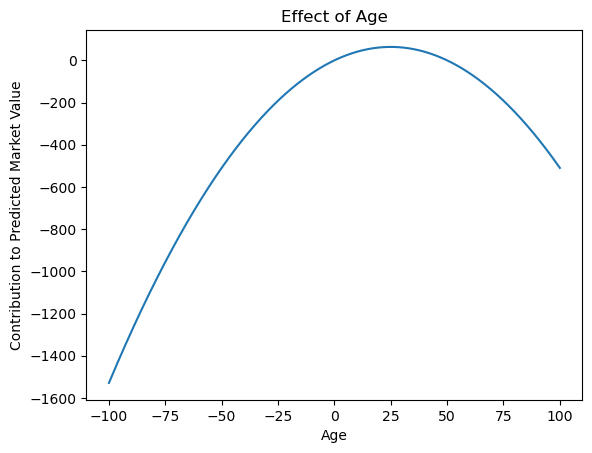

In [42]:
x_vals = np.linspace(-100,100,1000)
y_vals = agecoef*x_vals +age2coef*x_vals**2
plt.plot(x_vals, y_vals)
plt.title("Effect of Age")
plt.xlabel("Age")
plt.ylabel("Contribution to Predicted Market Value")
plt.show()

<hr style='height:3px'>
### Part 2.3: Turning Categorical Variables into multiple binary variables
Of course, we have an error in how we've included player position. Even though the variable is numeric (1,2,3,4) and the model runs without issue, the value we're getting back is garbage. The interpretation, such as it is, is that there is an equal effect of moving from position category 1 to 2, from 2 to 3, and from 3 to 4, and that this effect is about -.61.

In reality, we don't expect moving from one position category to another to be equivalent, nor for a move from category 1 to category 3 to be twice as important as a move from category 1 to category 2. We need to introduce better features to model this variable.

We'll use `pd.get_dummies` to do the work for us.

In [58]:
train_design_recoded = pd.get_dummies(league_train, columns=['position_cat'], drop_first=True)
test_design_recoded = pd.get_dummies(league_test, columns=['position_cat'], drop_first=True)

train_design_recoded.head()

,name,club,age,position,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing,position_cat_2,position_cat_3,position_cat_4
229,Mamadou Sakho,Liverpool,27,CB,15.0,934,5.0,0.10%,35,2.0,France,0,3,10,1,0,False,True,False
287,DeAndre Yedlin,Newcastle+United,24,RB,5.0,764,4.5,5.20%,0,3.0,United States,0,2,13,0,0,False,True,False
27,Alexandre Lacazette,Arsenal,26,CF,40.0,1183,10.5,26.50%,0,2.0,France,1,3,1,1,0,False,False,False
44,Jordon Ibe,Bournemouth,21,RW,8.0,504,5.0,0.40%,36,1.0,England,0,1,2,0,0,False,False,False
355,Alfie Mawson,Swansea,23,CB,6.0,509,5.0,1.80%,94,1.0,England,0,2,16,0,1,False,True,False


We've removed the original `position_cat` column and created three new ones.

#### Why only three new columns?
Why does pandas give us the option to drop the first category? 

<div class="exercise"><b>Exercise</b></div>
**Questions**:
1. If we're fitting a model without a constant, should we have three dummy columns or four dummy columns?
2. Fit a model and interpret the coefficient of `position_cat_2`.


In [56]:
print(train_design_recoded.dtypes)


name               object
club               object
age                 int64
position           object
market_value      float64
page_views          int64
fpl_value         float64
fpl_sel            object
fpl_points          int64
region            float64
nationality        object
new_foreign         int64
age_cat             int64
club_id             int64
big_club            int64
new_signing         int64
position_cat_2       bool
position_cat_3       bool
position_cat_4       bool
dtype: object


In [62]:
non_numeric_cols = ['name', 'club', 'position', 'fpl_sel', 'nationality']
train_design_clean = train_design_recoded.drop(columns=non_numeric_cols, errors='ignore')
test_design_clean = test_design_recoded.drop(columns=non_numeric_cols, errors='ignore')

# Convert bool columns to int (if any)
bool_cols = [col for col in train_design_clean.columns if train_design_clean[col].dtype == 'bool']
for col in bool_cols:
    train_design_clean[col] = train_design_clean[col].astype(int)
    test_design_clean[col] = test_design_clean[col].astype(int)

train_design_clean = sm.add_constant(train_design_clean)
test_design_clean = sm.add_constant(test_design_clean)


In [63]:
resu = OLS(y_train, train_design_clean).fit()
resu.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           market_value   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.393e+29
Date:                Fri, 23 May 2025   Prob (F-statistic):               0.00
Time:                        21:32:44   Log-Likelihood:                 10412.
No. Observations:                 368   AIC:                        -2.079e+04
Df Residuals:                     353   BIC:                        -2.074e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.553e-15   1.44e-13     -0.025      0.980   -2.87e-13     2.8e-13
age              1.11e-16   7.44e-15      0.015      0.988   -1.45e-14    1.47e-14
market_value       1.0000   1.13e-15   8.84e+14      0.000       1.000       1.000
page_views     -1.216e-16   1.14e-17    -10.658      0.000   -1.44e-16   -9.92e-17
fpl_value      -1.776e-15   1.18e-14     -0.151      0.880   -2.49e-14    2.14e-14
fpl_points      2.828e-16   1.94e-16      1.459      0.146   -9.85e-17    6.64e-16
region         -1.388e-16   7.24e-15     -0.019      0.985   -1.44e-14    1.41e-14
new_foreign     5.329e-15   4.23e-14      0.126      0.900   -7.78e-14    8.84e-14
age_cat                 0   2.25e-14          0      1.000   -4.43e-14    4.43e-14
club_id         2.637e-16   1.18e-15      0.223      0.824   -2.06e-15    2.59e-15
big_club        8.882e-16   1.91e-14      0.047      0.963   -3.66e-14    3.84e-14
new_signing     2.665e-15   1.93e-14      0.138      0.890   -3.53e-14    4.06e-14
position_cat_2  3.331e-16   2.23e-14      0.015      0.988   -4.35e-14    4.42e-14
position_cat_3          0   2.15e-14          0      1.000   -4.24e-14    4.24e-14
position_cat_4 -6.661e-16   3.02e-14     -0.022      0.982   -6.01e-14    5.88e-14
==============================================================================
Omnibus:                      330.838   Durbin-Watson:                   1.404
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7524.734
Skew:                           3.813   Prob(JB):                         0.00
Kurtosis:                      23.799   Cond. No.                     2.68e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [68]:
y_pred_test = resu.predict(test_design_clean)

r2 = r2_score(y_test, y_pred_test)

r2

1.0

In [69]:
train_design_recoded.shape, y_train.shape

((368, 19), (368,))

**Answers**:
1. If our model does not have a constant, we must include all four dummy variable columns. If we drop one, we're not modeling any effect of being in that category, and effectively assuming the dropped category's effect is 0.
2. Being in position 2 (instead of position 1) has an impact between -1.54 and +2.38 on a player's market value. Since we're using an intercept, the dropped category becomes the baseline and the effect of any dummy variable is the effect of being in that category instead of the baseline category.

## Part 3: A nice trick for forward-backwards

XOR (operator ^) is a logical operation that only returns true when input differ. We can use it to implement forward-or-backwards selection when we want to keep track of whet predictors are "left" from a given list of predictors.

The set analog is "symmetric difference". From the python docs:

`s.symmetric_difference(t)	s ^ t	new set with elements in either s or t but not both`


In [51]:
set() ^ set([1,2,3])

{1, 2, 3}

In [52]:
set([1]) ^ set([1,2,3])

{2, 3}

In [53]:
set([1, 2]) ^ set([1,2,3])

{3}

<div class="exercise"><b>Exercise</b></div>

Outline a step-forwards algorithm which uses this idea

*your answer here*


In [70]:
import statsmodels.api as sm

def forward_selection(data, response, candidate_predictors):
    remaining = set(candidate_predictors)
    selected = set()
    best_score = float('-inf')
    best_model = None

    while remaining:
        scores_with_candidates = []

        for candidate in remaining:
            # Try adding this candidate to the current set
            predictors = list(selected | {candidate})
            X = sm.add_constant(data[predictors])
            y = data[response]

            model = sm.OLS(y, X).fit()
            score = model.rsquared_adj  # or use model.aic, model.bic

            scores_with_candidates.append((score, candidate, model))

        # Find the best candidate this round
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate, model = scores_with_candidates[0]

        # Check if this improves our model
        if best_new_score > best_score:
            remaining ^= {best_candidate}  # XOR: remove from remaining
            selected ^= {best_candidate}   # XOR: add to selected
            best_score = best_new_score
            best_model = model
        else:
            break  # no improvement

    return best_model, selected
